In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Powershell Modules,91.221608,3.040720,30
Diffusers Library,221.534132,44.306826,5
Logging in Python,519.073855,20.762954,25
SharePoint,895.049310,52.649959,17
Azure Functions,938.109356,58.631835,16
Taxes,959.152192,106.572466,9
Azure AI Search,987.998452,70.571318,14
PP365,1085.368268,120.596474,9
Home Network Project,1337.269371,70.382598,19
Lost in a Good Book,1428.749901,71.437495,20


# Histogram

43719.21


<Axes: >

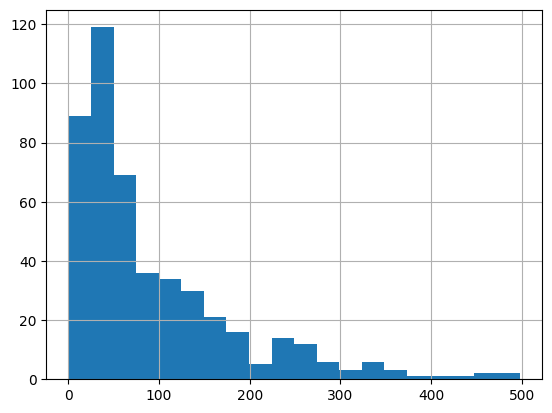

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [13]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [14]:
n = 6
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 470


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
1,WSL + Kali Linux,Tools for Troubleshooting GUI Apps on WSL:\nxp...,9816370d076d50e43bce4797f0bbd9d6,-497.415177,110.979348,-497.415177,3773.297849,0.745276,0,0
130,WSL + Kali Linux,DBus (Desktop Bus)\nAn inter-process communica...,043e5b1de72191858a863a7761fdc2a2,-354.452381,110.979348,-497.415177,3773.297849,0.745276,1,0
252,WSL + Kali Linux,VNC (Virtual Network Computing)\nA remote desk...,f5b53e9fe1c4e8df3144ea26cafa0e76,-251.680235,110.979348,-497.415177,3773.297849,0.745276,2,0
366,WSL + Kali Linux,Tools for Troubleshooting GUI Apps on WSL:\nxr...,b868411fcaac9b9b45f62aeb52011c88,-241.341194,110.979348,-497.415177,3773.297849,0.745276,3,0
2,WSL + Kali Linux,10. wsl --set-default <distro>\nSets the defau...,3200b4a1487366266f736fa8a39481b6,-195.023802,110.979348,-497.415177,3773.297849,0.745276,4,0
131,WSL + Kali Linux,Tools for Troubleshooting GUI Apps on WSL:\nxs...,adb0c5b44a17f16e3e3af02d0c82ac18,-152.448145,110.979348,-497.415177,3773.297849,0.745276,5,0
16,OData,$format Query Option\n\nDefinition: An OData q...,88eda4ed8730c804bb37e6daf4f3b7cb,-495.897923,170.106919,-495.897923,3232.031467,0.701453,0,0
145,OData,Versioning\n\nDefinition: The practice of evol...,d47fc6ea67123971018a4ff223ac9d08,-469.209313,170.106919,-495.897923,3232.031467,0.701453,1,0
265,OData,A Delta Token is a marker used in Delta Querie...,270357be923c5353b7ca10ff98de8dc7,-362.428129,170.106919,-495.897923,3232.031467,0.701453,2,0
379,OData,Formatting Instructions are guidelines that sp...,f15b0cabf509e1a15070569e23f1d7ab,-284.921767,170.106919,-495.897923,3232.031467,0.701453,3,0


## Age Mean

In [15]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [16]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
1,WSL + Kali Linux,Tools for Troubleshooting GUI Apps on WSL:\nxp...,9816370d076d50e43bce4797f0bbd9d6,-497.415177,110.979348,-497.415177,3773.297849,0.745276,0,0
130,WSL + Kali Linux,DBus (Desktop Bus)\nAn inter-process communica...,043e5b1de72191858a863a7761fdc2a2,-354.452381,110.979348,-497.415177,3773.297849,0.745276,1,0
252,WSL + Kali Linux,VNC (Virtual Network Computing)\nA remote desk...,f5b53e9fe1c4e8df3144ea26cafa0e76,-251.680235,110.979348,-497.415177,3773.297849,0.745276,2,0
366,WSL + Kali Linux,Tools for Troubleshooting GUI Apps on WSL:\nxr...,b868411fcaac9b9b45f62aeb52011c88,-241.341194,110.979348,-497.415177,3773.297849,0.745276,3,0
2,WSL + Kali Linux,10. wsl --set-default <distro>\nSets the defau...,3200b4a1487366266f736fa8a39481b6,-195.023802,110.979348,-497.415177,3773.297849,0.745276,4,0
131,WSL + Kali Linux,Tools for Troubleshooting GUI Apps on WSL:\nxs...,adb0c5b44a17f16e3e3af02d0c82ac18,-152.448145,110.979348,-497.415177,3773.297849,0.745276,5,0
16,OData,$format Query Option\n\nDefinition: An OData q...,88eda4ed8730c804bb37e6daf4f3b7cb,-495.897923,170.106919,-495.897923,3232.031467,0.701453,0,0
145,OData,Versioning\n\nDefinition: The practice of evol...,d47fc6ea67123971018a4ff223ac9d08,-469.209313,170.106919,-495.897923,3232.031467,0.701453,1,0
265,OData,A Delta Token is a marker used in Delta Querie...,270357be923c5353b7ca10ff98de8dc7,-362.428129,170.106919,-495.897923,3232.031467,0.701453,2,0
379,OData,Formatting Instructions are guidelines that sp...,f15b0cabf509e1a15070569e23f1d7ab,-284.921767,170.106919,-495.897923,3232.031467,0.701453,3,0


In [18]:
existing_cards.head(10)['age'].sum()

np.float64(-3304.818065098402)